### Metric methods for a regression problem

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering,KMeans,SpectralClustering
from sklearn.metrics import mean_squared_error
from collections import OrderedDict


In [2]:
def generate_clustering(data,method,n):
    if method=="Kmeans":
        kmeans = KMeans(n_clusters=n,random_state=14).fit(data)
        return kmeans.predict(data)
    elif method=="Spectral":
        spectral = SpectralClustering(n,random_state=17)
        return spectral.fit_predict(data)
    else:
        agg = AgglomerativeClustering()
        return agg.fit_predict(data)
    return X

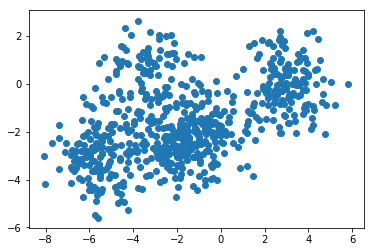

In [5]:
n=3#number of clusters
np.random.seed(37)
data = np.vstack(((np.random.randn(150, 2)  + np.array([3, 0])),
               (np.random.randn(100, 2)  + np.array([-3.5, 0.5])),
               (np.random.randn(100, 2) + np.array([-0.5, -2])),
               (np.random.randn(150, 2) + np.array([-2, -2.5])),
               (np.random.randn(150, 2) + np.array([-5.5, -3]))))

clusters = generate_clustering(data,"Spectral",n)
X = np.hstack([data,clusters.reshape(-1,1)])

plt.scatter(X[:,0],X[:,1])

train,test = train_test_split(X)
X_tr,Y_tr = train[:,:2],train[:,2]
X_t,Y_t = test[:,:2],test[:,2]

C:\Users\alexa\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


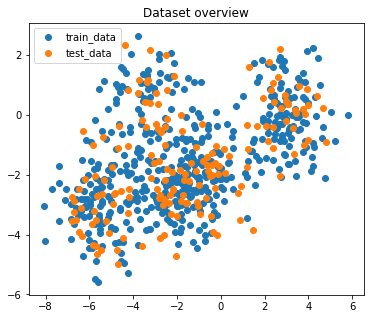

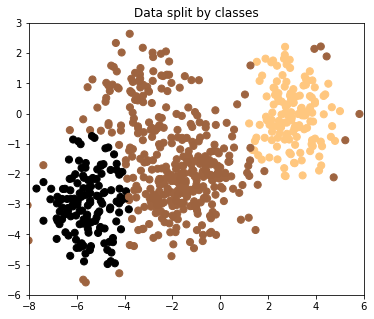

In [7]:
a1 = plt.figure(figsize=(6,5))
plt.scatter(X_tr[:,0],X_tr[:,1],label='train_data')
plt.scatter(X_t[:,0],X_t[:,1],label='test_data')

plt.title("Dataset overview")
plt.legend()
a1.show()
visualise_classes(train,test,Y_t.astype(int),demo=True,figsize=(6,5))

### Naive approach - KNN for regression

In [ ]:
class KNN(object):
    """
    KNN for classification 
    
    Argumants:
    ---------
    k -- number of nearest neighbours
    X -- input matrix of shape ()
    n -- number of classes
    method -- str -- can use 'parzen' or 'potentials'. Otherwise, will run simple KNN
    
    """
    def euclidean_dist(self,x,y):
        """
        euclidean distance between points x and y
        """
        if type(x)==np.float64:
            return ((y-x)**2)**0.5
        return sum((y[i]-x[i])**2 for i in range(len(x)))**0.5
    
    
    def split_data(self):
        train_data, test_data = train_test_split(self.X)
        self.X_train, self.Y_train = train_data[:,:2],train_data[:,2]
        self.X_test, self.Y_test = test_data[:,:2],test_data[:,2]
        
        
    def __init__(self,k,X=None,X_train=None,X_test=None,Y_train=None,Y_test=None):
        self.k = k
        if X is None:
            self.X_train,self.X_test = X_train,X_test
            self.Y_train,self.Y_test = Y_train,Y_test
            self.n = len(np.unique(Y_tr))
        else:
            self.X = X
            self.split_data()
            self.n = len(np.unique(X[:,-1]))
        
            
    def get_neighbours(self,point,flag=None):
        """
        Arguments:
        ---------
        point -- array of shape(,), chosen point from test
        Returns:
        ---------
        list of indices of k nearest points
        
        """
        #calculate k closest points from train
        distances = {self.euclidean_dist(self.X_train[i],point) : i for i in range(len(self.X_train)) if (self.X_train[i]!=point).all() }
        distances = OrderedDict(sorted(distances.items()))
        
        if flag=="parzen":
            return distances
        
        #return indices of k closest points
        k_nearest = list(distances.items())[:self.k]
        return [row[1] for row in k_nearest]
        
        
    def vote(self,k_neighbours):
        """
        returns most frequent class among k_neighbours
        """
        return np.argmax(np.bincount(self.Y_train.astype(int)[k_neighbours]))
        
        
    def predict(self):
        """
        returns predictions for test set
        """
        prediction = []
        # for each point in test 
        for point in self.X_test:
            #get indexes of k closest points
            k_neighbours = self.get_neighbours(point)
            #select class based on 'voting' process
            prediction.append(self.vote(k_neighbours))
        self.pred = np.array(prediction)
        return self.pred
    
    def calculate_accuracy(self):
        count = sum(1 for i in range(len(self.pred)) if self.pred[i]==self.Y_test[i])
        return count/len(self.pred)

In [8]:
class KNN_regression(object):
    """
    KNN for regression
    
    Arguments:
    ---------
    k -- number of nearest neighbours
    X -- input matrix
    """
    
    def split_data(self):
        train,test = train_test_split(self.X)
        self.X_train,self.X_test = train[:,0],test[:,0]
        self.Y_train,self.Y_test = test[:,1],test[:,1]

    
    def __init__(self,k,X = None, X_train=None, X_test = None, Y_train = None, Y_test = None):
        self.k = k
        if X is None:
            self.X_train, self.X_test  = X_train, X_test
            self.Y_train, self.Y_test  = Y_train, Y_test
        else:
            self.X = X
            self.split_data()
    
    def euclidean_dist(self,x,y):
        """
        euclidean distance between points x and y
        """
        if type(x)==np.float64:
            return (((y-x)**2)**0.5)
        return sum((y[i]-x[i])**2 for i in range(len(x)))**0.5
      
    def predict_average(self,distances):
        return np.mean(distances)
    
    def get_Neighbours(self,point):
        """
        Arguments:
        ---------
        point -- chosen point from X_test
        
        Returns:
        ------
        list of k closest neighbours [[distance,index],...]
        """
        distances = {self.euclidean_dist(self.X_train[i],point):i for i in range(len(self.X_train))}
        distances = OrderedDict(sorted(distances.items()))
        
        k_nearest = list(distances.items())[:self.k]
        return [row[0] for row in k_nearest]

    def predict(self):
        prediction = []
        for point in self.X_test:
            #get k neighbours
            neighbours = self.get_Neighbours(point)
            #predict price based on their values
            prediction.append(self.predict_average(neighbours))
        self.pred = np.array(prediction)
        return self.pred
    
    
    def calculate_accuracy(self):
        return mean_squared_error(self.Y_test,self.pred)
    
    def visualize(self):
        plt.figure(figsize=(20,10))
    
        plt.plot(self.X_train,self.Y_train,'ro',label='train points')
        plt.plot(self.X_test,self.Y_test,'go',label='test points')
        plt.plot(self.X_test,self.pred,'bo',label='preduicted points')
    
    
        plt.legend()
        plt.show()

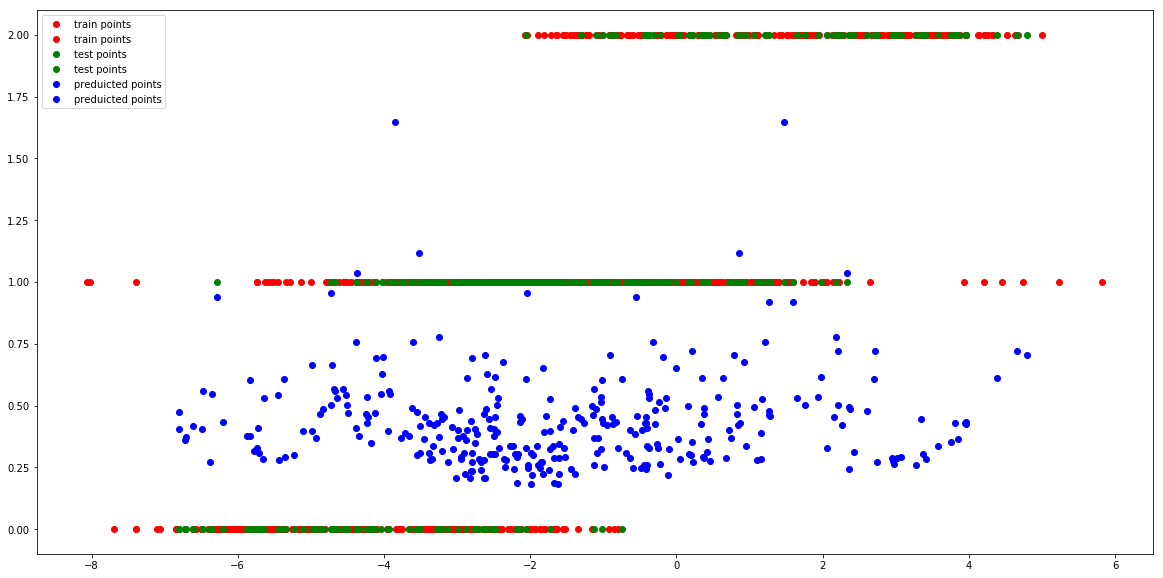

In [11]:
model = KNN_regression(10,X_train=X_tr,X_test=X_t,Y_train=Y_tr,Y_test=Y_t)
prediction = model.predict()
model.calculate_accuracy()
model.visualize()

In [72]:
def GD_fit(X,Y,l=0.0001,epochs = 1000):
    """
    Arguments:
    l -- learning rate
    epochs -- number of iterations
    X -- training set of X
    Y -- training set of Y
    Output:
    m,b -- params of Y = m*X+b - m is the slope, b is the intercept
    """
    n,m,b =len(X),0,0 #initial values
     
    for i in range(epochs):
        Y_pred = [m*x_i+b for x_i in X]
        D_m = (-2/n) * sum(x_i *(y_i-y_pred_i) for x_i,y_i,y_pred_i in zip(X,Y,Y_pred))
        D_b = (-2/n) * sum(y-y_i for y,y_i in zip(Y,Y_pred))
        m-=l*D_m
        b-=l*D_b
    return m,b


def GD_predict(x,m,b):
    return m*x + b


def test_GD(X_train,Y_train,X_test,Y_test):
    m,b = GD_fit(X_train,Y_train,0.001,1200)
    pred = np.array([GD_predict(i,m,b) for i in X_test])
    loss = mean_squared_error(Y_test,pred)
    print("loss = {0}".format(loss))
    visualize(X_train,Y_train,X_test,Y_test,Y_pred=pred)

loss = 2.293682039391939


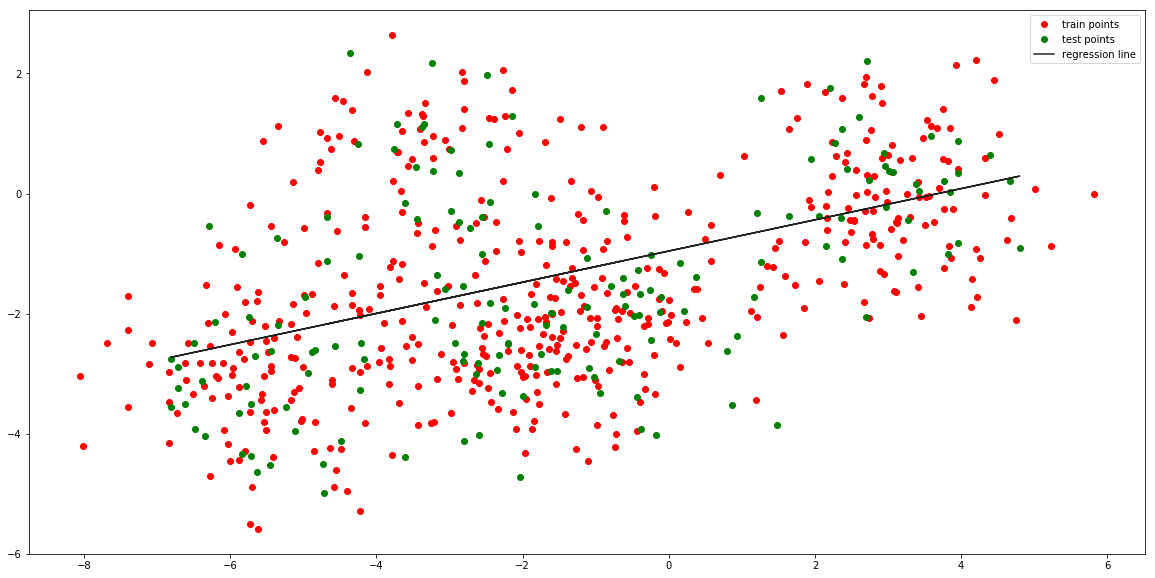

In [73]:
test_GD(X_tr,Y_tr,X_t,Y_t)

In [6]:
def visualize(X,Y,X_test,Y_test,Y_pred=[]):
    plt.figure(figsize=(20,10))
    
    plt.plot(X,Y,'ro',label='train points')
    plt.plot(X_test,Y_test,'go',label='test points')
    
    if type(Y_pred)==np.ndarray:
        plt.plot(X_test,Y_pred,'#222222',label = 'regression line')
    
    plt.legend()
    plt.show()

In [6]:
def visualise_classes(train,test,pred_labels,figsize=(15,10),data=None,demo=False):
    plt.figure(figsize=figsize)
    
    if data is not None:
        train = data
    
    c = len(np.unique(train[:,-1]))
    colormap = plt.cm.binary_r
    colors =[x/(2*c) for x in range(2*c)]
    
    train_map = [colors[i] for i in train[:,-1].astype(int)]
    
    if data is None:
        test_map = [colors[i+c] for i in test[:,-1].astype(int)]
        pred_map = [colors[i+c] for i in pred_labels[:]]

    plt.scatter(train[:,0],train[:,1],c = train_map,cmap=plt.cm.copper,s=50,marker='o')
    if demo:
        plt.scatter(test[:,0],test[:,1],c = test_map,cmap=plt.cm.copper,s=50,marker='o')
    elif data is None:
        plt.scatter(test[:,0],test[:,1],c = pred_map,cmap=plt.cm.flag_r,s=120,marker='o')
        plt.plot([],marker='o',ms=10,ls="",color="b",label="Train")
        plt.plot([],marker='o',ms=16,ls="",color="b",label="Pred")
        plt.legend()

    plt.title('Data split by classes')
    plt.axis([-8,6,-6,3]) 
    plt.show()